In [1]:
import calendar
from pathlib import Path
from typing import TYPE_CHECKING, cast

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from cartopy.mpl.ticker import LatitudeFormatter, LongitudeFormatter

if TYPE_CHECKING:
    from cartopy.mpl.geoaxes import GeoAxes

In [40]:
model_tracks_directory = Path("D://nccs-transport/tracks/model/")

# Surface runs are bad still, don't use. Will replace with 1-day surface runs eventually.
surface_model_trajectory_zarr_list = list(model_tracks_directory.glob("*_surface_only*.zarr"))
surface_model_trajectory_zarr_list.sort()

depth_model_trajectory_zarr_list = list(model_tracks_directory.glob("*150m*.zarr"))
depth_model_trajectory_zarr_list.sort()

In [41]:
alitmeter_tracks_directory = Path("D://nccs-transport/tracks/altimeter/")

altimeter_trajectory_zarr_list = list(alitmeter_tracks_directory.glob("*.zarr"))
altimeter_trajectory_zarr_list.sort()

In [ ]:
model_surface_traj: xr.Dataset = xr.concat(
    [xr.open_zarr(f) for f in surface_model_trajectory_zarr_list],
    dim="trajectory",
    compat="no_conflicts",
    coords="minimal",
)
model_depth_traj: xr.Dataset = xr.concat(
    [xr.open_zarr(f) for f in depth_model_trajectory_zarr_list],
    dim="trajectory",
    compat="no_conflicts",
    coords="minimal",
)

altimeter_traj: xr.Dataset = xr.concat(
    [xr.open_zarr(f) for f in altimeter_trajectory_zarr_list],
    dim="trajectory",
    compat="no_conflicts",
    coords="minimal",
)

# Why do I need to do this? Ty is still alpha...
model_surface_traj = cast("xr.Dataset", model_surface_traj)
model_depth_traj = cast("xr.Dataset", model_depth_traj)
altimeter_traj = cast("xr.Dataset", altimeter_traj)

model_surface_traj["age"] -= model_surface_traj["age"][:, 0]
model_depth_traj["age"] -= model_depth_traj["age"][:, 0]
altimeter_traj["age"] -= altimeter_traj["age"][:, 0]
model_surface_traj["age"] /= 86400
model_depth_traj["age"] /= 86400
altimeter_traj["age"] /= 86400

In [44]:
def select_month(ds: xr.Dataset, month: int) -> xr.Dataset:
    """Select trajectories that start in a given month.

    Args:
        ds (xr.Dataset): Dataset containing trajectories.
        month (int): Month to select (1-12).

    Returns:
        xr.Dataset: Dataset containing only trajectories that start in the given month.

    """
    return ds.where((ds.isel(obs=0).drop_vars("obs")["time.month"] == month).compute(), drop=True)

In [49]:
def calculate_histogram(
    ds: xr.Dataset,
    lat_min: float,
    lat_max: float,
    dlat: float,
    lon_min: float,
    lon_max: float,
    dlon: float,
) -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """Calculate 2D histogram of latitude and longitude positions from Parcels output.

    Args:
        ds (xr.Dataset): Dataset containing 'latitude' and 'longitude'
        lat_min (float): Minimum latitude for histogram bins.
        lat_max (float): Maximum latitude for histogram bins.
        dlat (float): Latitude bin size.
        lon_min (float): Minimum longitude for histogram bins.
        lon_max (float): Maximum longitude for histogram bins.
        dlon (float): Longitude bin size.

    Returns:
        tuple: Histogram array, latitude bin centers, latitude bin edges, longitude bin centers, longitude bin edges.

    """
    lat_bins = np.arange(lat_min, lat_max + dlat, dlat)
    lon_bins = np.arange(lon_min, lon_max + dlon, dlon)

    histogram, lat_edges, lon_edges = np.histogram2d(
        ds["lat"].values.flatten(),
        ds["lon"].values.flatten(),
        bins=[lat_bins, lon_bins],
    )

    histogram[histogram == 0] = np.nan

    return histogram, lat_bins, lat_edges, lon_bins, lon_edges

Text(0.5, 0.93, 'Model mean particle density after 365 days by release month - only surviving particles')

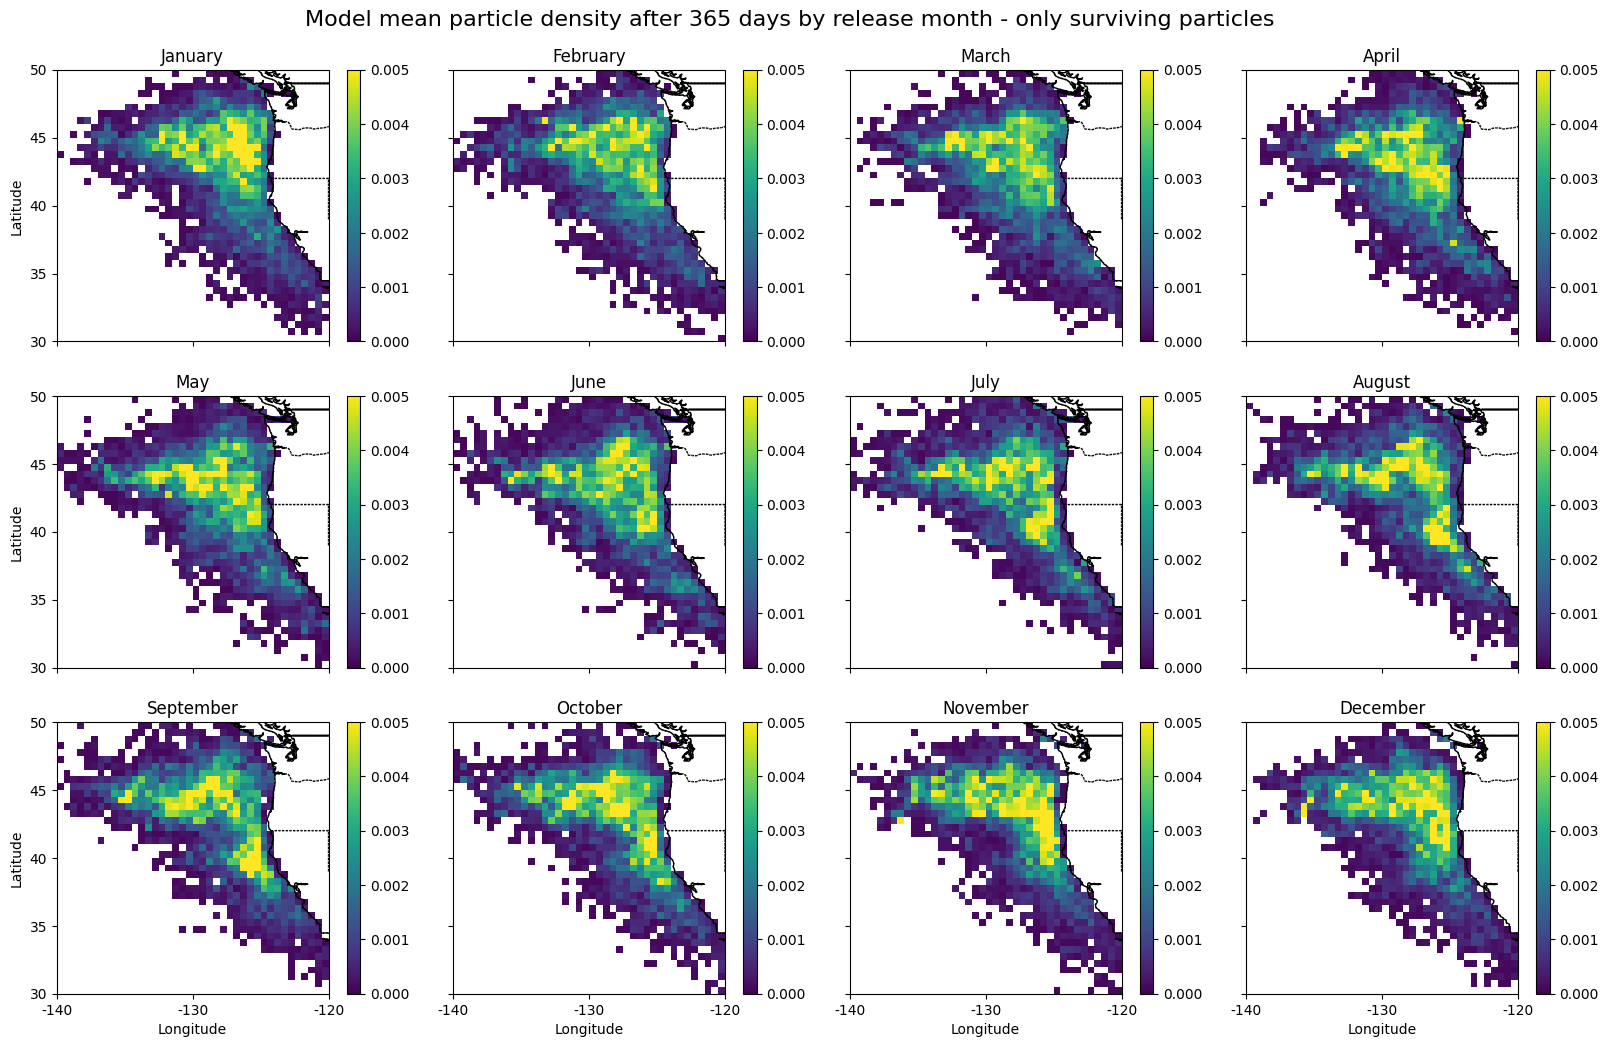

In [61]:
nrows, ncols = 3, 4
fig, axs = plt.subplots(nrows, ncols, figsize=(20, 12), subplot_kw={"projection": ccrs.PlateCarree()})
plt.subplots_adjust(wspace=0.1, hspace=0.2)

# For plot axis limits
lon_min, lon_max = -140, -120
lat_min, lat_max = 30, 50

for month in range(1, 13):
    ds = select_month(model_depth_traj, month).isel(obs=365)
    histogram, lat_bin_centers, _, lon_bin_centers, _ = calculate_histogram(
        ds,
        lat_min,
        lat_max,
        0.5,
        lon_min,
        lon_max,
        0.5,
    )

    row = (month - 1) // 4
    col = (month - 1) % 4
    # Need to explicitly cast to GeoAxes for type checking,
    # since plt.subplots doesn't return different types based on subplot_kw
    ax = cast("GeoAxes", axs[row, col])
    ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

    pcm = ax.pcolormesh(
        lon_bin_centers,
        lat_bin_centers,
        histogram / np.nansum(histogram),
        vmin=0,
        vmax=0.005,
        cmap="viridis",
        shading="auto",
        rasterized=True,
        transform=ccrs.PlateCarree(),
    )
    fig.colorbar(pcm, ax=ax, orientation="vertical")

    ax.set_title(str(calendar.month_name[month]))
    ax.set_xticks(np.arange(lon_min, lon_max + 1, 10), crs=ccrs.PlateCarree())
    ax.set_yticks(np.arange(lat_min, lat_max + 1, 5), crs=ccrs.PlateCarree())
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    if row == nrows - 1:
        ax.set_xlabel("Longitude")
        lon_formatter = LongitudeFormatter()
        ax.xaxis.set_major_formatter(lon_formatter)
        ax.set_xticklabels(np.arange(lon_min, lon_max + 1, 10))
    if col == 0:
        ax.set_ylabel("Latitude")
        lat_formatter = LatitudeFormatter()
        ax.yaxis.set_major_formatter(lat_formatter)
        ax.set_yticklabels(np.arange(lat_min, lat_max + 1, 5))

    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linestyle="-", linewidth=1.5)
    ax.add_feature(cfeature.STATES, linestyle=":")

plt.suptitle(
    "Model mean particle density after 365 days by release month - only surviving particles",
    fontsize=16,
    y=0.93,
)

Text(0.5, 0.93, 'Altimetry based mean particle density after 365 days by release month - only surviving particles')

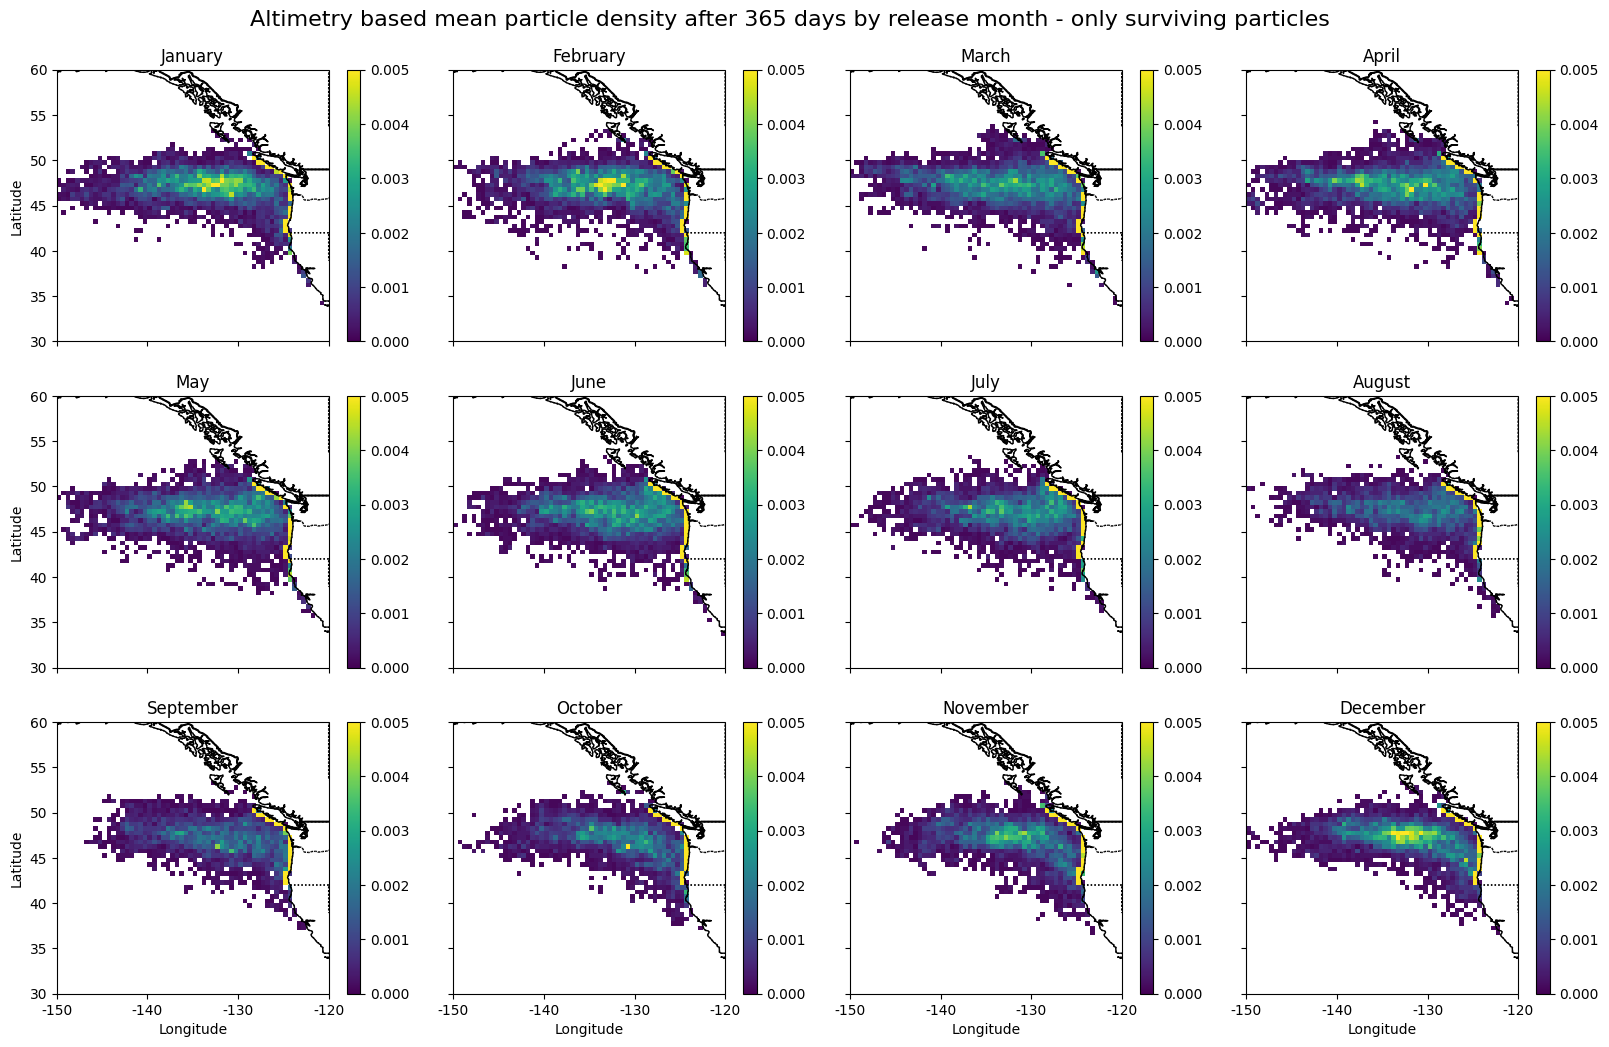

In [63]:
nrows, ncols = 3, 4
fig, axs = plt.subplots(nrows, ncols, figsize=(20, 12), subplot_kw={"projection": ccrs.PlateCarree()})
plt.subplots_adjust(wspace=0.1, hspace=0.2)

# For plot axis limits
lon_min, lon_max = -150, -120
lat_min, lat_max = 30, 60

for month in range(1, 13):
    ds = select_month(altimeter_traj, month).isel(obs=365)
    histogram, lat_bin_centers, _, lon_bin_centers, _ = calculate_histogram(
        ds,
        lat_min,
        lat_max,
        0.5,
        lon_min,
        lon_max,
        0.5,
    )

    row = (month - 1) // 4
    col = (month - 1) % 4
    # Need to explicitly cast to GeoAxes for type checking,
    # since plt.subplots doesn't return different types based on subplot_kw
    ax = cast("GeoAxes", axs[row, col])
    ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

    pcm = ax.pcolormesh(
        lon_bin_centers,
        lat_bin_centers,
        histogram / np.nansum(histogram),
        vmin=0,
        vmax=0.005,
        cmap="viridis",
        shading="auto",
        rasterized=True,
        transform=ccrs.PlateCarree(),
    )
    fig.colorbar(pcm, ax=ax, orientation="vertical")

    ax.set_title(str(calendar.month_name[month]))
    ax.set_xticks(np.arange(lon_min, lon_max + 1, 10), crs=ccrs.PlateCarree())
    ax.set_yticks(np.arange(lat_min, lat_max + 1, 5), crs=ccrs.PlateCarree())
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    if row == nrows - 1:
        ax.set_xlabel("Longitude")
        lon_formatter = LongitudeFormatter()
        ax.xaxis.set_major_formatter(lon_formatter)
        ax.set_xticklabels(np.arange(lon_min, lon_max + 1, 10))
    if col == 0:
        ax.set_ylabel("Latitude")
        lat_formatter = LatitudeFormatter()
        ax.yaxis.set_major_formatter(lat_formatter)
        ax.set_yticklabels(np.arange(lat_min, lat_max + 1, 5))

    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linestyle="-", linewidth=1.5)
    ax.add_feature(cfeature.STATES, linestyle=":")

plt.suptitle(
    "Altimetry based mean particle density after 365 days by release month - only surviving particles",
    fontsize=16,
    y=0.93,
)